<img src="../../img/timeseries_smoothing.png" alt="time series smoothing" style="width: 100%; border-radius: 20px;"/>

## Objective
In the prior notebook `05_continuous_change_point_detection`, it was found that using rolling window averaging is not scientifically accurate for inferring systematic drifts in bird species. This notebook will implement an approach that uses the ration of presence and absence of a bird species within a week (7 days) as the y-value of the time series, rather than the number of sightings.

> Instead of using decades (10-day periods) as is often done in ornithological studies, @Christopher König recommended using 7-day periods. 10-day periods can sometimes encompass two weekends, and user bias tends to increase the number of sightings on weekends, so by using 7-day periods, we ensure that each weekday is represented only once.

## Scope
The steps to create presence-based time series will be detailed in this notebook. These include aggregating sightings in weeks and replacing the number of sightings with the ratio of days where sightings occurred. The focus will be on preprocessing the time series data to reduce biases and fluctuations, and to make the patterns of systematic drift more discernible for subsequent analysis. The potential effectiveness of this approach and the need for further assessment and potential adjustments in future work will also be discussed.

In [37]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import pandas as pd

from utils.plotting import *

import warnings
warnings.filterwarnings('ignore')

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following file is required:
- Time series of bird sightings: *[time_series_27_species.csv](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e)*

In [35]:
path_sightings = '../../../01_Data/datasets/time_series_27_species.csv'

target_path = '../../../01_Data/datasets/'

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣  Load raw data </p>

As a first step, the time series that were generated in `04_timeseries_construction.ipynb` are loaded. Below are two exemplary time series depicting the sighting frequencies for the pygmy owl (Sperlingskauz) and the icterine warbler (Gelbspötter) over the entire observation period from 2018 to 2022 in a 50x50km grid around Basel (CH) and Hannover (DE), respectively.

In [3]:
time_series = pd.read_csv(path_sightings)
time_series['date'] = pd.to_datetime(time_series['date'])

In [4]:
pygmy_owl = time_series[(time_series.name_species == 'Sperlingskauz') & (time_series.eea_grid_id == '50kmE4100N2700')].reset_index(drop=True)
plot_time_series(data=pygmy_owl, title='Pygmy owl (Sperlingskauz) sightings in grid 50kmE4100N2700 (raw)')

In [5]:
warbler = time_series[(time_series.name_species == 'Gelbspötter') & (time_series.eea_grid_id == '50kmE4350N3250')].reset_index(drop=True)
plot_time_series(data=warbler, title='Icterine warbler (Gelbspötter) sightings in grid 50kmE4350N3250 (raw)')

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Preprocessing using week counts </p>
The visualization above demonstrates that the raw time series display spikes, fluctuations, and irregularities. These fluctuations can make it difficult to accurately identify significant changes in the underlying pattern of the time series. Additionally, noise in the unsmoothed data may obscure genuine change points, impacting the reliability of the analysis.

Another problem with using the time series data in its original form is that relying on the exact number of sightings to estimate the actual population of birds is not scientifically accurate. This number does not reflect the true number of birds present, but rather the frequency of reports submitted to ornitho. The same bird may be reported multiple times by different users, or multiple birds may be sighted but only one reported. Therefore, using this number as a metric for the population size of a species in a specific area would lead to incorrect conclusions.

Therefore, we have decided to preprocess the time series as follows:

- Sightings for each species and grid are aggregated in weeks (7 days).
- In each week, the number of days with a sighting of the corresponding species is counted. The number of sightings is not considered, thus removing the influence of the user biases described above.
- The value of the time series is the relative number of days with a sighting. For example, if the Great Crested Grebe is sighted in Grid 50kmE4350N3250 on two out of 7 days in the first week, the y-value for that week is 2/7, so ~0.29.

To do this, each day of the five years is assigned to a week from 1 to 52. In order to be able to distinguish the years later, the dataframe is expanded with a column `year`.

In [22]:
df = time_series.copy()
df = df.sort_values('date')
df['year'] = df['date'].dt.year
df['week'] = (df['date'].dt.dayofyear - 1) // 7 + 1
df = df[df['week'] <= 52]

Then, the columns are sorted for better readability and the `date` column is dropped as it is no longer needed.

In [23]:
weeks = df.sort_values(by=['name_species', 'eea_grid_id', 'date', 'year'])
weeks.drop('date', axis=1, inplace=True)
weeks.head(10)

,name_species,eea_grid_id,n_sightings,year,week
7555988,Alpenschneehuhn,50kmE4000N2500,0.0,2018,1
7555989,Alpenschneehuhn,50kmE4000N2500,0.0,2018,1
7555990,Alpenschneehuhn,50kmE4000N2500,0.0,2018,1
7555991,Alpenschneehuhn,50kmE4000N2500,0.0,2018,1
7555992,Alpenschneehuhn,50kmE4000N2500,0.0,2018,1
7555993,Alpenschneehuhn,50kmE4000N2500,0.0,2018,1
7555994,Alpenschneehuhn,50kmE4000N2500,0.0,2018,1
7555995,Alpenschneehuhn,50kmE4000N2500,0.0,2018,2
7555996,Alpenschneehuhn,50kmE4000N2500,0.0,2018,2
7555997,Alpenschneehuhn,50kmE4000N2500,0.0,2018,2


Now, an example excerpt of the time series data looks like this:

In [24]:
pygmy_owl_filter = (weeks.name_species == 'Sperlingskauz') & (weeks.eea_grid_id == '50kmE4100N2700') & (weeks.year == 2022) 
weeks[pygmy_owl_filter].head(10)

,name_species,eea_grid_id,n_sightings,year,week
5645627,Sperlingskauz,50kmE4100N2700,3.0,2022,1
5645628,Sperlingskauz,50kmE4100N2700,2.0,2022,1
5645629,Sperlingskauz,50kmE4100N2700,1.0,2022,1
5645630,Sperlingskauz,50kmE4100N2700,0.0,2022,1
5645631,Sperlingskauz,50kmE4100N2700,0.0,2022,1
5645632,Sperlingskauz,50kmE4100N2700,0.0,2022,1
5645633,Sperlingskauz,50kmE4100N2700,0.0,2022,1
5645634,Sperlingskauz,50kmE4100N2700,4.0,2022,2
5645635,Sperlingskauz,50kmE4100N2700,3.0,2022,2
5645636,Sperlingskauz,50kmE4100N2700,1.0,2022,2


Next, a groupby operation is performed, and the ratio of sightings where the number of sightings is greater than 0 is calculated for each grouped object. This ratio is stored in the new column `sighting_ratio`.

In [30]:
week_counts = weeks.groupby(['name_species', 'eea_grid_id', 'year', 'week']).apply(lambda x: round((x['n_sightings'] > 0).sum() / 7, 2)).reset_index(name='sighting_ratio')

In the excerpt below, the correct calculation can be verified exemplarily. From the dataframe above, it can be determined that the pygmy owl was observed one or more times on three out of seven days during the first week of 2022 within the grid 50kmE4100N2700. Accordingly, the corresponding entry in the `sighting_ratio` column of the new dataframe correctly contains a value of ~0.43.

In [31]:
pygmy_owl_filter = (week_counts.name_species == 'Sperlingskauz') & (week_counts.eea_grid_id == '50kmE4100N2700') & (week_counts.year == 2022)
week_counts[pygmy_owl_filter].head(10)

,name_species,eea_grid_id,year,week,sighting_ratio
1264588,Sperlingskauz,50kmE4100N2700,2022,1,0.43
1264589,Sperlingskauz,50kmE4100N2700,2022,2,0.57
1264590,Sperlingskauz,50kmE4100N2700,2022,3,0.00
1264591,Sperlingskauz,50kmE4100N2700,2022,4,0.57
1264592,Sperlingskauz,50kmE4100N2700,2022,5,0.14
1264593,Sperlingskauz,50kmE4100N2700,2022,6,0.71
1264594,Sperlingskauz,50kmE4100N2700,2022,7,0.29
1264595,Sperlingskauz,50kmE4100N2700,2022,8,0.14
1264596,Sperlingskauz,50kmE4100N2700,2022,9,0.14
1264597,Sperlingskauz,50kmE4100N2700,2022,10,0.00


Below, the two time series from Chapter 1️⃣ are visualized after the preprocessing steps. 
> To enhance visual clarity, lines are drawn between the bars.
 
Instead of specific dates, the data is now grouped by weeks. Additionally, to facilitate comparison of the years, the time series are segmented by year and displayed as multiple time series. This approach enables easier identification of yearly patterns and differences.

For instance, in the case of the pygmy owl, a clear upward trend in sightings and sighting durations in the specified grid is evident. Initially, there are no sightings in 2018. However, as the years progress, the bird is observed more frequently and for longer periods. Between the weeks 25 and 34, sightings stay rare, with an exception of a single day of sighting(s) in 2022.

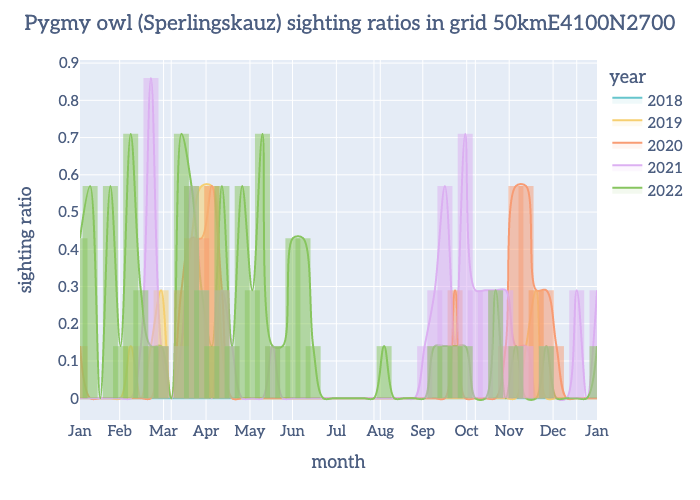

In [38]:
pygmy_owl = week_counts[(week_counts['name_species'] == 'Sperlingskauz') & (week_counts['eea_grid_id'] == '50kmE4100N2700')]
plot_sighting_ratios_over_year(pygmy_owl, title='Pygmy owl (Sperlingskauz) sighting ratios in grid 50kmE4100N2700')


For the icterine warbler in the specified grid, we can clearly observe that sightings not only occur for longer durations throughout the year, but this bird is also sighted more regularly, meaning it is observed on more days within a 7-day period, giving it higher time series values.

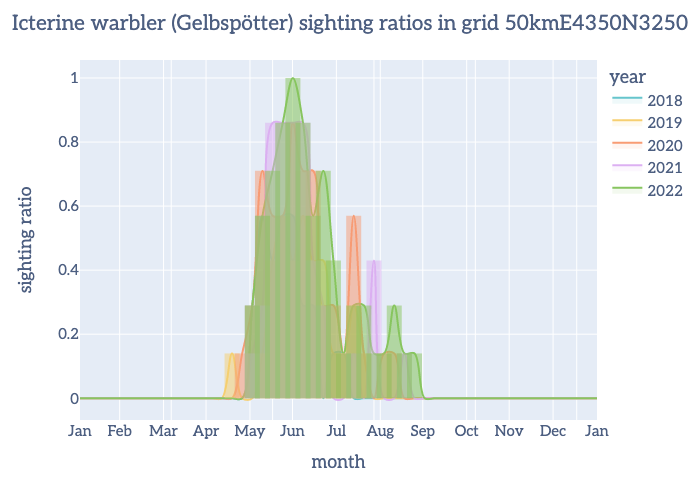

In [39]:
warbler = week_counts[(week_counts['name_species'] == 'Gelbspötter') & (week_counts['eea_grid_id'] == '50kmE4350N3250')]
plot_sighting_ratios_over_year(warbler, title='Icterine warbler (Gelbspötter) sighting ratios in grid 50kmE4350N3250')

The preprocessed time series can be stored as well for further usage:

In [36]:
week_counts.to_csv(target_path + 'time_series_27_species_week_counts.csv', index=False)

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 5️⃣ Discussion and Outlook </p>

The time series with smoothed week information will be leveraged in the following Master Thesis of Marina Siebold to detect shifts in the birds distribution and sighting days.

We believe that the chosen preprocessing approach is a meaningful method for reducing spikes, fluctuations, and sighting biases, making the patterns of systematic drift more readily discernible for both humans and algorithms. However, whether the selected preprocessing approach is truly effective remains to be assessed within the scope of the subsequent work and may require adjustments or revisions if necessary.